In [39]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torch
from lovely_tensors import monkey_patch
from src.guided_backprop import GuidedBackpropReLU
monkey_patch()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
a = torch.randn(2, 4, requires_grad=True)
print(a)
a_standard = torch.randn(2, 4, requires_grad=True)
print(a_standard)


tensor[2, 4] n=8 x∈[-2.373, 0.829] μ=-0.127 σ=1.075 grad [[-2.373, 0.829, -0.074, 0.588], [-1.061, 0.488, 0.399, 0.186]]
tensor[2, 4] n=8 x∈[-1.770, 1.799] μ=0.310 σ=1.178 grad [[1.246, -1.770, 0.280, -0.387], [1.476, -0.354, 0.191, 1.799]]


In [41]:
in_r = GuidedBackpropReLU.apply(a)
print(f"in_r: {in_r}")
in_r *= -1
loss = in_r.sum()
print(f"loss: {loss}")

in_r: tensor[2, 4] n=8 x∈[0., 0.829] μ=0.311 σ=0.314 grad GuidedBackpropReLUBackward [[0., 0.829, 0., 0.588], [0., 0.488, 0.399, 0.186]]
loss: -2.488527297973633


In [42]:
from torch.nn.functional import relu
in_r_standard = relu(a_standard)
print(f"in_r_standard: {in_r_standard}")
in_r_standard *= -1
loss_standard = in_r_standard.sum()
print(f"loss_standard: {loss_standard}")

in_r_standard: tensor[2, 4] n=8 x∈[0., 1.799] μ=0.624 σ=0.753 grad ReluBackward0 [[1.246, 0., 0.280, 0.], [1.476, 0., 0.191, 1.799]]
loss_standard: -4.9911675453186035


In [43]:
# Clear the gradients
a.grad = None
a_standard.grad = None
# Check the gradients
loss.backward(retain_graph=True)
print(f"a.grad: {a.grad}")
# loss_standard.backward(retain_graph=True)
# print(f"a.grad_standard: {a_standard.grad}")


a.grad: tensor[2, 4] n=8 all_zeros [[0., 0., 0., 0.], [0., 0., 0., 0.]]


In [44]:
import torch
import torchvision.transforms.functional as torchvisionF
from torchvision import datasets as tds
from torchvision.transforms import Lambda

from src.utils import XILUtils

device = XILUtils.define_device()
num_classes = 2

transform_func_device = Lambda(lambda i: torchvisionF.to_tensor(i).to(device=device))
ds_train = tds.MNIST(
    root="data/",
    train=True,
    download=True,
    transform=transform_func_device,
)

ds_test = tds.MNIST(
    root="data/",
    train=False,
    download=True,
    transform=transform_func_device,
)

train_dataset_length = -1

labels = [0, 8]
train_indices = [i for i, (_, label) in enumerate(ds_train) if label in labels][:train_dataset_length]
test_indices = [i for i, (_, label) in enumerate(ds_test) if label in labels]
ds_train = torch.utils.data.Subset(ds_train, train_indices)
ds_test = torch.utils.data.Subset(ds_test, test_indices)

# Set target_transform attribute
target_transform = Lambda(lambda y: torch.zeros(2, dtype=torch.float, device=device).scatter_(0, torch.tensor(
    0 if y == 0 else 1, device=device), value=1))
ds_train.dataset.target_transform = target_transform
ds_test.dataset.target_transform = target_transform
from torch.utils.data import DataLoader

tr = ds_train.dataset.target_transform
print(f"{ds_train.dataset.targets=}")

batch_size = 64

# create dataloader
train_dataloader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

train_dl_iterator = iter(train_dataloader)
test_dl_iterator = iter(test_dataloader)

curr_batch = next(train_dl_iterator)
x_it, t_it = curr_batch


ds_train.dataset.targets=tensor[60000] i64 0.5Mb x∈[0, 9] μ=4.454 σ=2.889


In [45]:
from src.guided_backprop import GuidedBackpropagation

from src.experiments.cnn import CNNTwoConv

model = CNNTwoConv(num_classes=num_classes)

In [46]:
from pathlib import Path
DIR = Path("08_MNIST_output/")
model.load_state_dict(torch.load(DIR / "confounded_ds_model.pth", weights_only=True))
model.eval()


CNNTwoConv(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
    (4): Softmax(dim=1)
  )
)

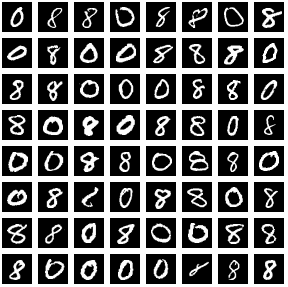

In [47]:
x_it.repeat(1, 3, 1, 1).rgb

In [48]:
for i in model.children():
    print(i)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=1568, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=2, bias=True)
  (4): Softmax(dim=1)
)


In [49]:
model_2 = CNNTwoConv(num_classes, device)
model_2.load_state_dict(model.state_dict())
guided_backprop_model = GuidedBackpropagation(model_2, device)
guided_backprop_model.model.eval()


GuidedBackpropReLUModel(
  (model): CNNTwoConv(
    (features): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GuidedBackpropReLUModule()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): GuidedBackpropReLUModule()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (classifier): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=1568, out_features=128, bias=True)
      (2): GuidedBackpropReLUModule()
      (3): Linear(in_features=128, out_features=2, bias=True)
      (4): Softmax(dim=1)
    )
  )
)

In [50]:
test = guided_backprop_model.generate_gradients(x_it, t_it)

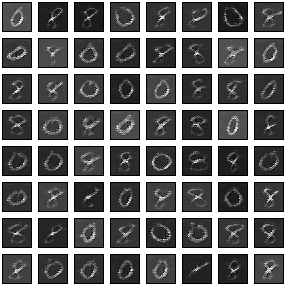

In [51]:
test = XILUtils.minmax_normalize_tensor(test)
test.repeat(1, 3, 1, 1).rgb

In [52]:
test_2 = guided_backprop_model.generate_gradients(x_it, t_it)


In [53]:
test_2 = XILUtils.minmax_normalize_tensor(test_2)

In [54]:
print(f"{test}\n\n{test_2}")

tensor[64, 1, 28, 28] n=50176 (0.2Mb) x∈[0., 1.000] μ=0.234 σ=0.120 mps:0

tensor[64, 1, 28, 28] n=50176 (0.2Mb) x∈[0., 1.000] μ=0.234 σ=0.120 mps:0


In [55]:
test_2 - test

tensor[64, 1, 28, 28] n=50176 (0.2Mb) all_zeros mps:0

In [56]:
model_2.eval()

CNNTwoConv(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
    (4): Softmax(dim=1)
  )
)